# Importación de librerías  

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
warnings.filterwarnings('ignore')

# Cargue de datos

In [2]:
# Leer archivos csv
def leer_archivos (path):
    """
    Lee un archivo csv y retorna un dataframe
    :param path: str: path del archivo csv
    :return: DataFrame: dataframe con los datos del archivo
    """
    df = pd.read_csv(path)
    return df

df_pobreza_desigualdad = leer_archivos("../data/clean/pobreza_desigualdad.csv")
df_pobreza_desigualdad.head()

,tipo_area,region,tenencia_viv,linea_indig,linea_pobreza,hogar_pobre,hogar_indigente,num_pobres,num_indigentes,factor_exp,...,jh_genero,jh_edad,jh_afiliado_seguridad_social,jh_nivel_educativo,jh_situacion_laboral,jh_cotizacion_pension,jh_posicion_ocupacional,jh_horas_trabajo_semanales,total_dependientes,ingreso_per_capita
0,cabecera,RESTO URBANO,En arriendo o subarriendo,211838.33655,393677.759609,no,no,0,0,131.723106,...,Femenino,32,Si,Tecnológica,Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",1.0,7.333361e+05
1,cabecera,RESTO URBANO,"Propia, la están pagando",211838.33655,393677.759609,no,no,0,0,83.471732,...,Femenino,48,Si,Técnica profesional,Trabajando,Si,Trabajador por cuenta propia,Más de 40 horas,0.0,1.425000e+06
2,cabecera,RESTO URBANO,En usufructo,211838.33655,393677.759609,no,no,0,0,106.360970,...,Masculino,68,Si,Media académica (Bachillerato clásico),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,5.000000e+05
3,cabecera,RESTO URBANO,En usufructo,211838.33655,393677.759609,no,no,0,0,106.360970,...,Masculino,80,Si,Básica primaria (1o - 5o),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,7.333333e+04
4,resto,RURAL,En arriendo o subarriendo,164635.13660,270748.848811,no,no,0,0,27.049855,...,Femenino,39,Si,Media académica (Bachillerato clásico),Oficios del hogar,No,Trabajador por cuenta propia,Más de 40 horas,2.0,3.956002e+06


In [3]:
df_pobreza_desigualdad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277158 entries, 0 to 277157
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   tipo_area                     277158 non-null  object 
 1   region                        277158 non-null  object 
 2   tenencia_viv                  277158 non-null  object 
 3   linea_indig                   277158 non-null  float64
 4   linea_pobreza                 277158 non-null  float64
 5   hogar_pobre                   277158 non-null  object 
 6   hogar_indigente               277158 non-null  object 
 7   num_pobres                    277158 non-null  int64  
 8   num_indigentes                277158 non-null  int64  
 9   factor_exp                    277158 non-null  float64
 10  total_personas_hogar          277158 non-null  int64  
 11  ingresos_laborales            277158 non-null  float64
 12  ingresos_subsidios            277158 non-nul

El DataFrame analizado `df_pobreza_desigualdad` contiene un total de 277,158 registros y 31 columnas, proporcionando un conjunto de datos detallados sobre las características socioeconómicas de los hogares en Colombia. Las columnas incluyen variables categóricas, como `tipo_area`, `region`, y `tenencia_viv`, que representan aspectos geográficos y de vivienda, así como variables numéricas que abarcan desde ingresos y composición del hogar hasta indicadores de pobreza. 
Entre las variables numéricas, se encuentran datos críticos como `num_pobres`, `total_ingresos_hogar`, e `ingreso_per_capita`, que son fundamentales para el análisis de la pobreza y la desigualdad. 

Además, el DataFrame incluye información sobre la situación laboral y educativa del jefe de hogar a través de columnas como `jh_situacion_laboral`, `jh_nivel_educativo`, y `jh_horas_trabajo_semanales`. La mayoría de las columnas no presentan valores nulos, a excepción de `jh_nivel_educativo`, que cuenta con 2 entradas sin información (se validó en la data original del DANe y estos registros nulos tenian originalmente el valor de 99 que corresponde a 'No sabe, no informa' por tanto fueron imputados con este valor). 

Sobre este conjunto de datos, se llevó a cabo un análisis descriptivo y aplicar técnicas de segmentación y clustering con el fin de abordar la segmentación de los hogares de manera precisa, lo que permitirá a CARE diseñar e implementar estrategias de intervención más específicas y efectivas.

In [4]:
# Imputar los NaN en la columna jh_nivel_educativo
df_pobreza_desigualdad['jh_nivel_educativo'].fillna('No sabe, no informa', inplace=True)

# Análisis descriptivo y visualización

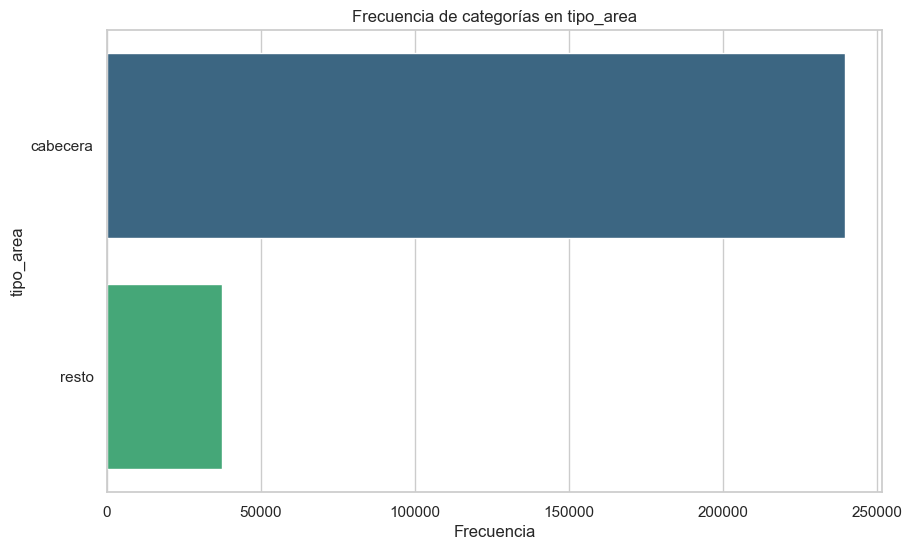

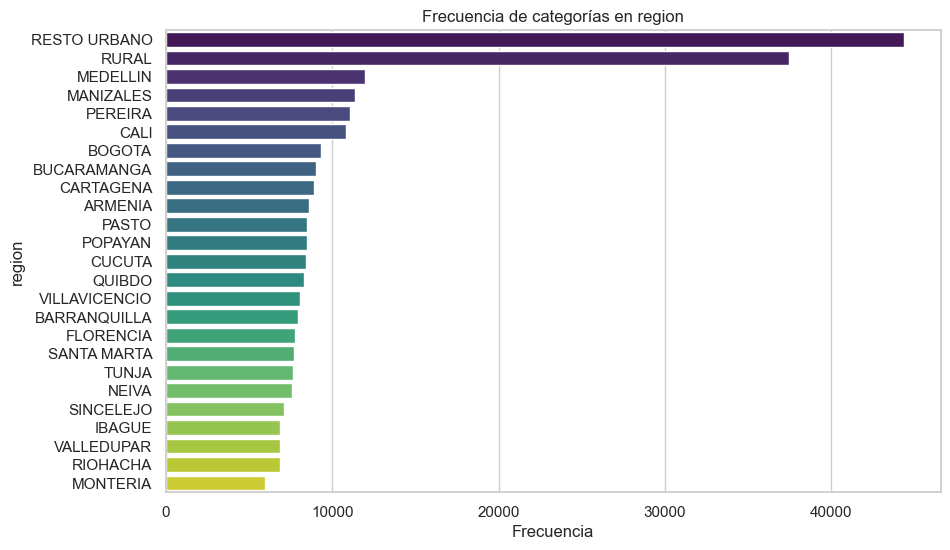

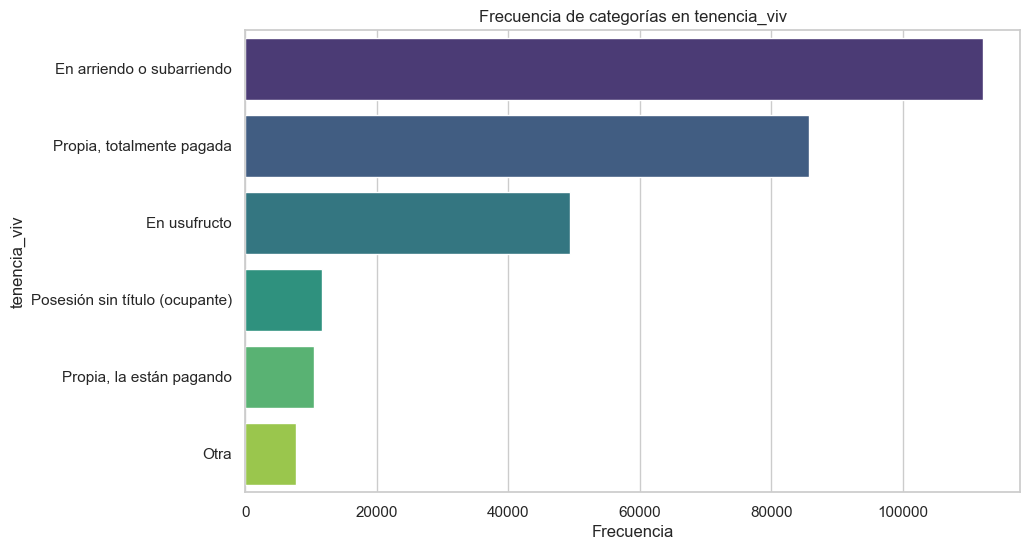

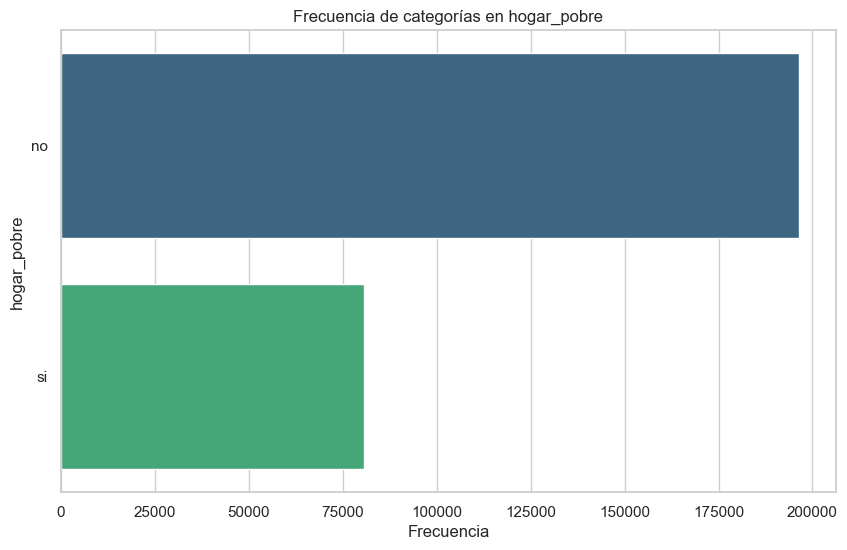

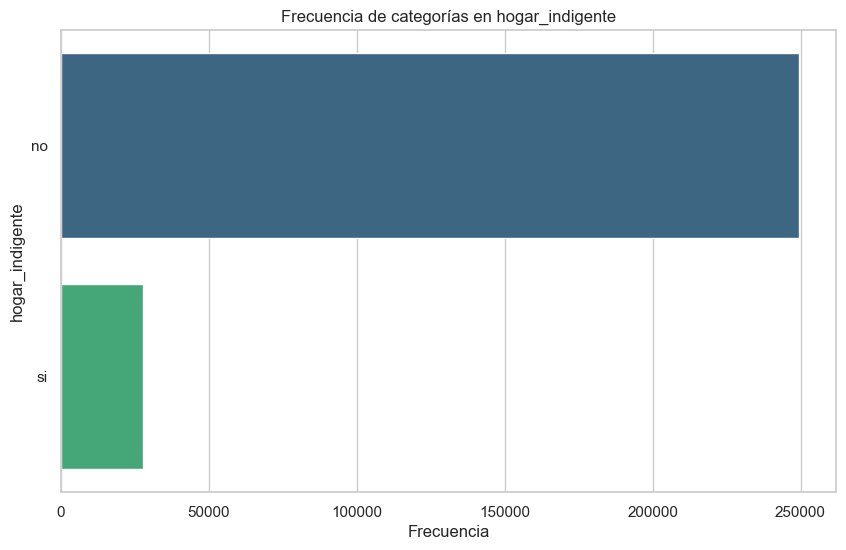

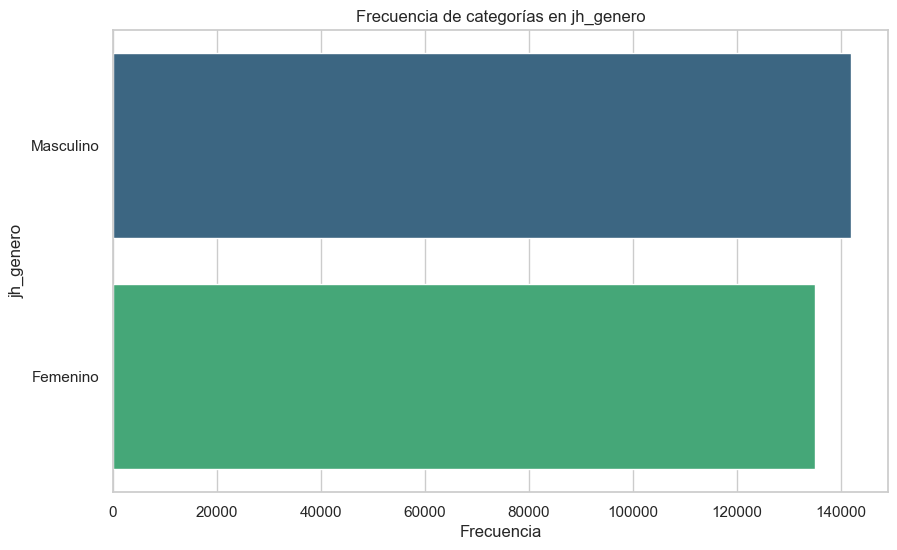

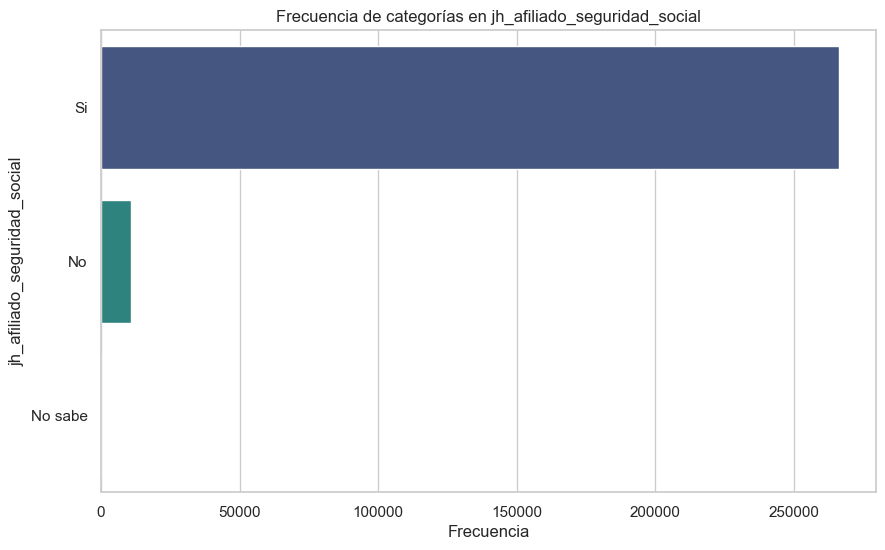

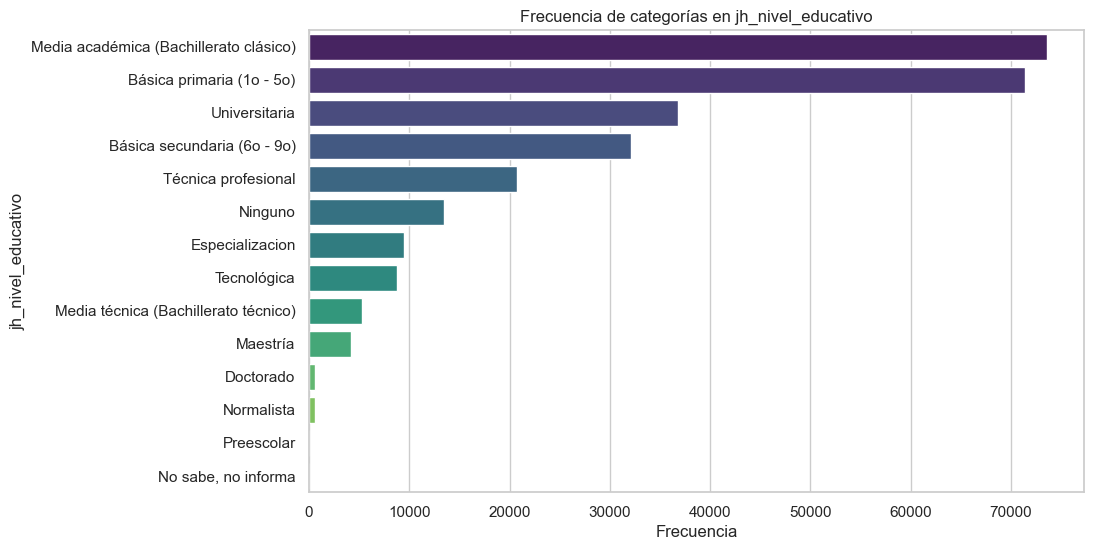

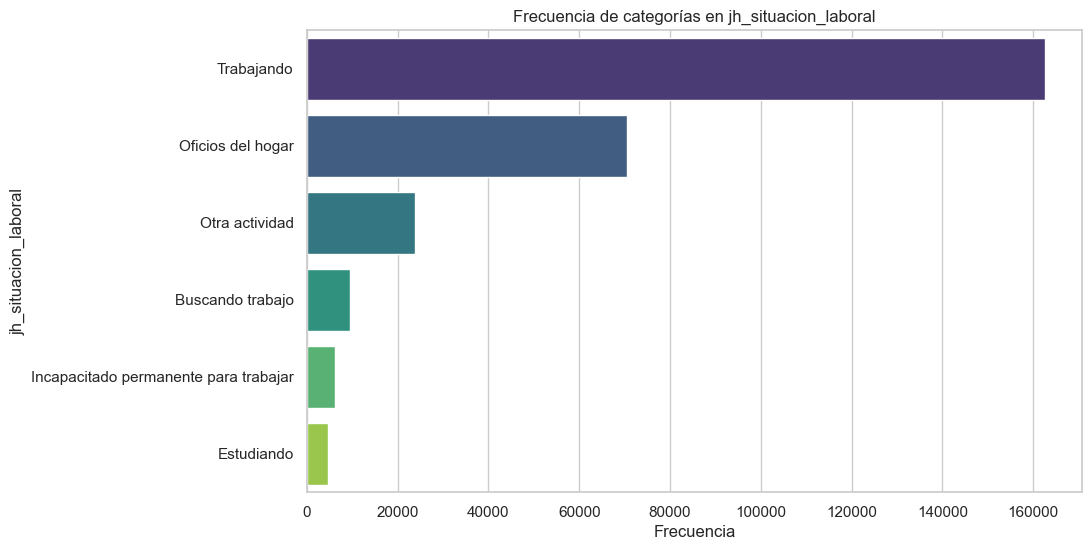

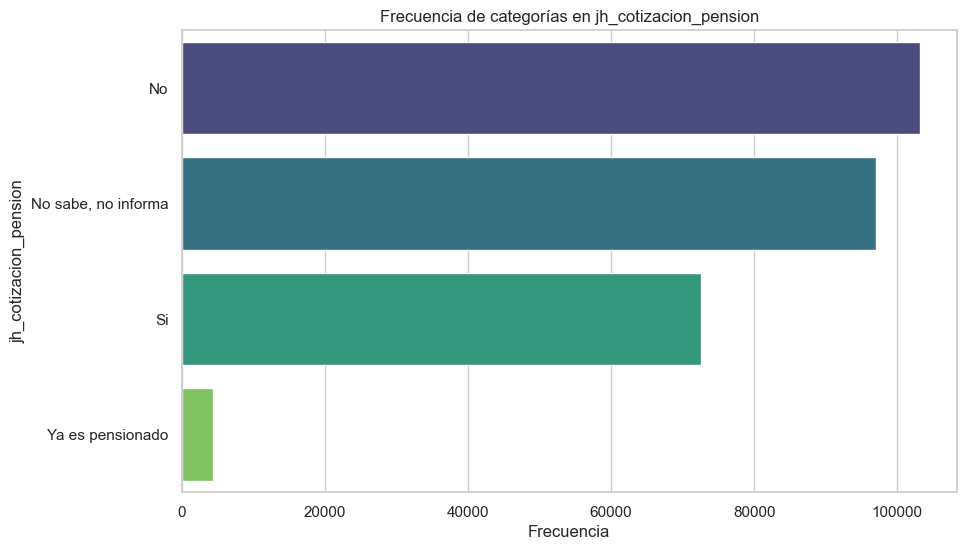

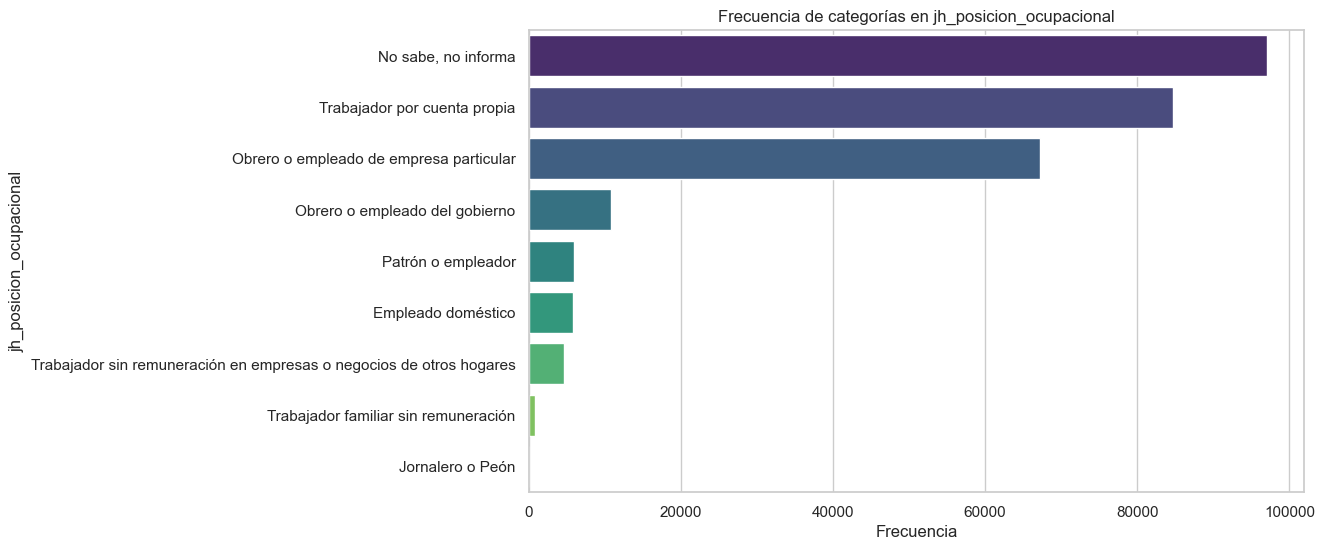

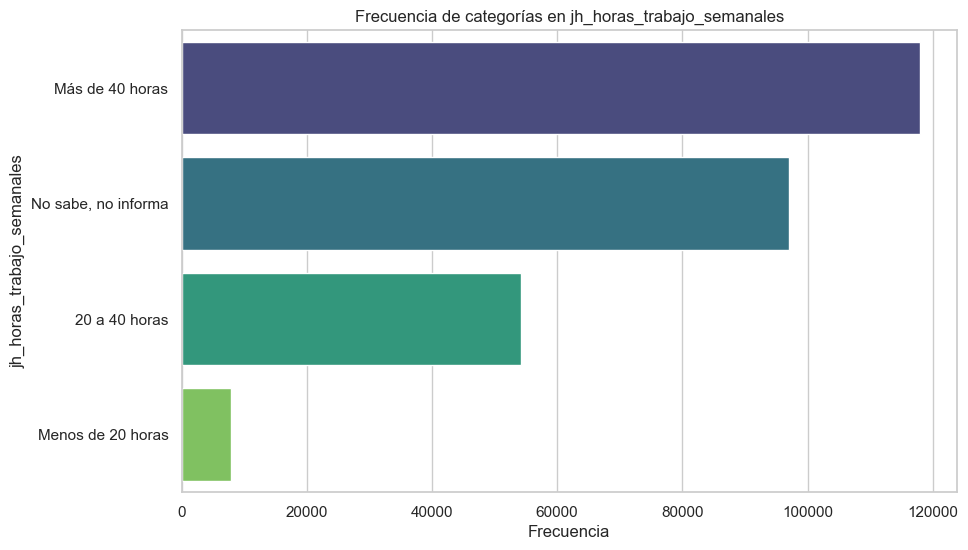

In [5]:
# Función para crear gráficos de barras horizontales para variables categóricas de forma independiente
def graficar_variables_categoricas(df):
    """
    Crea gráficos de barras horizontales para las columnas categóricas de tipo object en el DataFrame
    en gráficos independientes.

    Parameters:
        df (pd.DataFrame): DataFrame que contiene los datos.
    """
    # Filtrar columnas de tipo object
    columnas_categoricas = df.select_dtypes(include=['object']).columns
    
    # Configurar el estilo de Seaborn
    sns.set(style='whitegrid', palette='viridis')
    
    # Crear un gráfico independiente para cada columna categórica
    for col in columnas_categoricas:
        # Calcular la frecuencia de cada categoría
        frecuencia = df[col].value_counts().reset_index()
        frecuencia.columns = [col, 'frecuencia']

        # Crear el gráfico de barras horizontales
        plt.figure(figsize=(10, 6))  # Tamaño de figura mediano
        sns.barplot(data=frecuencia, x='frecuencia', y=col, palette='viridis')
        plt.title(f'Frecuencia de categorías en {col}')
        plt.xlabel('Frecuencia')
        plt.ylabel(col)
        plt.show()  # Mostrar el gráfico

# Ejemplo de uso
# Cargar tu DataFrame aquí (df)
# df = cargar_datos_csv_desde_url(url_csv)  # Reemplaza con tu URL

graficar_variables_categoricas(df_pobreza_desigualdad)

* `tipo_area`clasifica los hogares en dos categorias: **cabecera** y **resto**. Predominan los hogares en áres de cabecera con una participación de 86.49% en comparación con los hogares ubicados en zonas rurales o menos urbanizadas (13.51%)
* `region`categoriza los hogares segun diferentes ubicacione geográficas en Colombia. La mayoría de los hogares se concentra en áreas urbana, especialmente en ciudades como **Medellín**, **Cali** y **Bogotá**. Las regiones rurales también tienen una representación significativa (13.51%), lo que indica que es importante considerar sus características al realizar la segmentación.
* `tenencia_viv`describe la situación de tenencia de la vivienda entre los hogares de estudio. Si bien, una alta proporción de hogares viven en arriendo o subarriendo (40.49%), otra proporción significativa de hogares posee su vivienda formal (30.91%). Existen tambien un porcentaje pequeño (4.73%) de hogares qen posición sin titulo y aquellos en proceso de pago (3.77%) que pudieran llegar a necesitar apoyo para la formalización de la propiedad y el acceso a la vivienda. 
* `hogar_pobre`indica la situación de pobreza de los hogares en el estudio. La mayoría de estos no se consideran pobres (70.87%), lo que es un indicador positivo de bienestar económico en una parte de la población. Sin embargo, el 29.23% de los hogares clasifican como pobres, sugiere la existencia de una población vulnerable que enfrenta desafíos significativos.
* `hogar_indigente`refleja la situación de indigencia de los hogares en estudio. La mayoria de los hogares (90.03%) no se consideran en indigencia, lo que es un indicador positivo a nivel general de bienestar en la población. No obstante el 10% de la población si clasifica como indigentes y resalta la necesidad de identificar las circunstancias de estos hogares que son candidatos a futuras intervenciones de la ONG Care.
* `jh_genero` representa el género del jefe de hogar. La distribución de géneros está relativamente equilibrada, con una ligera predominancia másculina (51.24%). La proporción significativa de hogares liderados por mujeres (48.76%) destaca la importancia de considerar las necesidades y desafíos específicos que enfrentan las familias con jefas femeninas dentro del contexto de la pobreza y acceso a recursos.
* `jh_afiliado_seguridad_social`indica si el jefe de hogar está afiliado a algun sistema de seguridad social en salud. La mayoría de los jefes de hogar se encuentra afiliado a un sistema de seguridad social(90.06%), lo que es un indicador positivo en términos de acceso a servicios de salud. No obstante un porcentaje pequeño (3.88%) no esta afiliado a ningún sistema de seguridad social, representando un grupo de la población que puede verse expuesto a riesgos de salud sin la cobertura adecuada. 
* `jh_nivel_educativo`refleja el nivel educativo del jefe del hogar. La mayoría de los jefes de hogar tienen al menos educación primaria, pero hay una notable caída en los niveles educativos superiores, lo que puede implicar barreras en el acceso a la educación y a oportunidades de desarrollo personal y profesional. En 4.87% de los hogares, el jefe de hogar no cuenta con educación formal, sugiriendo la implementación de iniciativas educativas y programas de concientización. 
* `jh_situacion_laboral`describe la situación laboral del jefe de hogar. La mayoría de los jefes de hogar estan en situación de trabajo (58.66%) lo que sugiere una economía activa y en movimiento. Una parte significativa de los jefes de hogar (25.44%) esta involucrado en oficidos de hogar, lo que puede subrayar la importancia del trabajo no remunerado en la estructura familiar y económica. Hay un bajo porcentaje de jefes de hogar estudiando (1.64%) y buscando trabajo (3.42%) lo que podria indicar barreras para la educación y el empleo, afectando el desarrollo económico y social. La pequeña proporción de personas incapacitadas para trabajar (2.21%) también merece atención para el desarrollo de políticas inclusivas. 
* `jh_cotizacion_pension` indica la situación de cotización a pensión del jefe de hogar. La mayor parte de los jefes de hogar no están cotizando a pensiones (37.22%) lo que sugiere que una gran parte de la población podría estar en riesgo de no tener un ingreso estable en la jubilación. Hay una proporción significa de jefes de hogar (35.01%) que no saben o no informan su situación de cotización y solo el 26.20% de los jefes de hogar está cotizando a pensiones. La baja tasa de personas pensionadas (1.57%) sugiere que la mayoría de los jefes de hogar aun tienen por delante en la fuerza laboral.
* `jh_posicion_ocupacional`representa la situación labora del jefe del hogar en terminos de su posición ocupacional. Una alta proporción de las personas encuestadas no saben o no proporcionan información de su posición ocupacional (35.01%), lo que destaca la necesidad de mejorar la recopilación de datos y la concientización sobre la situación laboral. La gran cantidad de trabajadores por cuenta propia (30.55%) sugiere una economia informal lo que podría tener implicaciones para el acceso a beneficios sociales y laborales. La representación relativamente baja de empleados del gobierno (3.92%) puede ser un reflejo de la estructura del pais, donde el sector privado es predominante. Las posiciones con menos representación (empleados domésticos, trabajadores sin remuneración) reflejan la diversidad de fuerza laboral y existencia de trabajo informal en la economía.
* `jh_horas_trabajo_semanales` refleja la cantidad de horas que el jefe e hogar trabaja en una semana. La proporción de hogares donde el jefe trabaja mas de 40 horas a la semana es 42.55%, lo cual es un reflejo de la legislación laboral colombiana actual en donde la jornada laboral tiene un máximo de 46 horas. La cantidad significativa de personas que no sabe o no informa sobre sus horas de trabajo (35.01%) refleja la necsidad de de mejorar la recolección de datos por parte del DANE. Finalmente una proporción pequeña de jefes de hogar (2.84%) trabajan menos de 20 horas, lo que sugiere que esta población tenga un empleo a tiempo parcial, generando efectos en la estabilidad financiera y la calidad de vida del hogar.

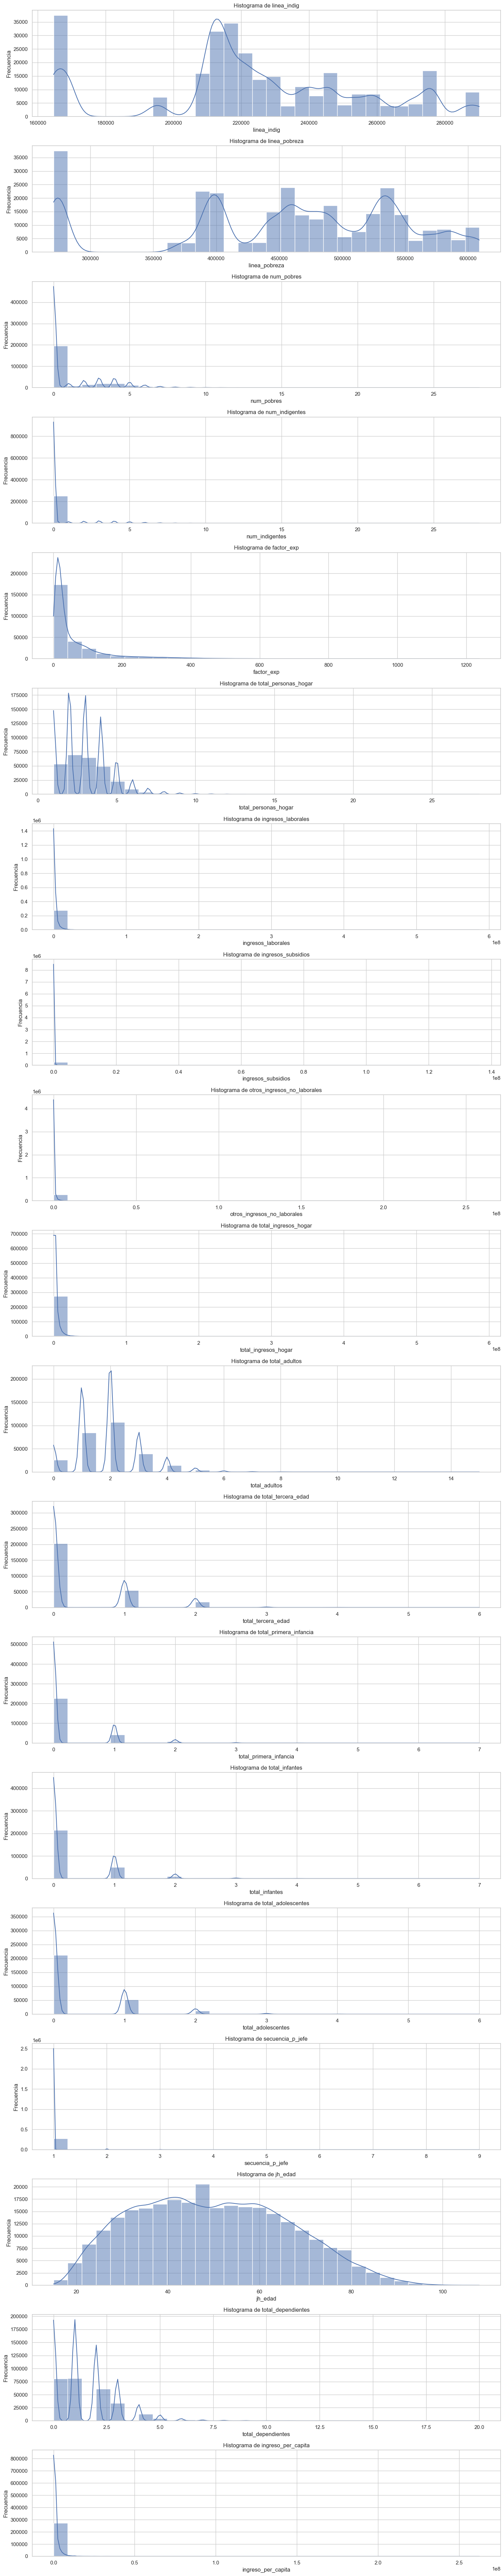

In [6]:
# Filtrar las columnas numéricas
columnas_numericas = df_pobreza_desigualdad.select_dtypes(include=['float64', 'int64']).columns

# Configurar el estilo de Seaborn
sns.set(style='whitegrid')

# Crear boxplots para cada variable numérica
plt.figure(figsize=(15, len(columnas_numericas) * 4))  # Ajustar el tamaño de la figura
for i, col in enumerate(columnas_numericas):
    plt.subplot(len(columnas_numericas), 1, i + 1)
    sns.histplot(df_pobreza_desigualdad[col], bins=30, kde=True, palette='viridis')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

* `linea_indig` la mayoría de los hogares se encuentran por encima de la línea de indigencia, pero con una desviación estandar considerable, lo que indica una amplia variación en los ingresos. 
* `linea_pobreza` Similar a la línea de indigencia, la linea de pobreza presenta una variabilidad notable, sugiriendo que hay hogares con ingresos muy distintos, incluso dentro de la pobreza.
* `num_pobres` la mayoría de los hogares reporta 1 o ningún miembro en situación de pobreza, aunque hay algunos hogares hasta con 28 personas en esta situación, lo que puede indicar graves problemas en la economía familiar. 
* `num_indigentes` Al igual que en las anteriores variables, la media sugiere que pocos hogares tienen indigentes, pero el valor máximo (28 personas) indica que algunos hogares están enfrentando crisis extremas. 
* `factor_exp`Este factor de expansión de los datos, tiene una alta variabilidad, lo que sugiere que algunas áreas están mucho más representadas que otras en la muestra. 
* `total_personas_hogar`: Un promedio de aproximadamente 3 personas por hogar es típico en muchas regiones, pero el rango máximo indica la posibilidad de hogares muy grandes (28 personas), lo que puede complicar la gestión de sus recursos.
* `ingresos_laborales`: La media (2481285) indica que muchos hogares dependen de ingresos laborales, aunque la alta desviación estándar (5289516) muestra una gran desigualdad en la remuneración. 
* `ingresos_subsidios`: Muchos hogares no dependen de subsidios, pero algunos reciben cantidades significativas, sugiriendo un sistema de ayuda muy variable. 
* `total_ingresos_hogar`: Existe una disparidad económica donde algunos hogares son mucho más ricos que otros, distorsionando la media (3.180.801)
* `ingreso_per_capita`:  El ingreso per cápita refuerza la desigualdad observada en los ingresos totales. 

En conclusión: 

* Desigualdad Económica: Los altos valores de desviación estándar en casi todas las variables sugieren una notable desigualdad económica entre los hogares, donde algunos enfrentan condiciones extremas mientras que otros están mucho mejor.
* Dependencia de Ingresos Laborales: La mayoría de los hogares dependen de ingresos laborales, pero la variabilidad de estos ingresos sugiere que se deben implementar políticas para mejorar las oportunidades de empleo y aumentar los salarios.
* Efecto de los Subsidios: Aunque los subsidios juegan un papel en la economía de algunos hogares, muchos no reciben ayuda, lo que puede aumentar la vulnerabilidad económica.
* Demografía del Hogar: El tamaño de los hogares es un factor importante a considerar en la formulación de políticas, especialmente en lo que respecta a la asignación de recursos y programas de asistencia.

# Procesamiento de datos

## Escalado de variables

In [7]:
# Identificar las columnas categóricas y numéricas
categorical_cols = df_pobreza_desigualdad.select_dtypes(include=['object']).columns
numeric_cols = df_pobreza_desigualdad.select_dtypes(include=['int64', 'float64']).columns

# Crear el transformador para escalar y codificar las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # Escalar las columnas numéricas
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # Codificar las columnas categóricas
    ])

# Aplicar las transformaciones al DataFrame
df_processed = preprocessor.fit_transform(df_pobreza_desigualdad)

# Convertir el resultado a DataFrame (opcional)
df_processed = pd.DataFrame(df_processed)
df_processed.shape

(277158, 86)

## Algoritmo K-Means

### Selección del número de clústeres. 

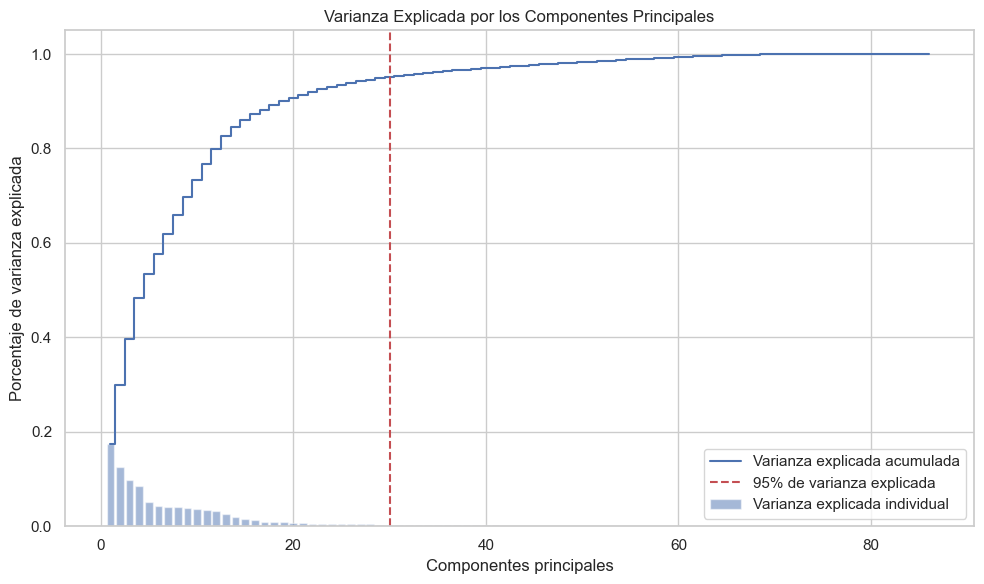

Número de componentes que explican el 95% de la varianza: 30


In [27]:
# Aplicamos PCA para reducir la dimensionalidad
# Aplicar PCA
pca = PCA()
df_pca = pca.fit_transform(df_processed)

# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Calcular la varianza explicada acumulada
cumulative_explained_variance = explained_variance.cumsum()

# Encontrar el número de componentes que explican al menos el 95% de la varianza
n_components_95 = (cumulative_explained_variance >= 0.95).argmax() + 1  # +1 porque el índice comienza en 0

# Graficar la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Varianza explicada acumulada')

# Añadir un punto para el 95%
plt.axvline(x=n_components_95, color='r', linestyle='--', label='95% de varianza explicada')

plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.title('Varianza Explicada por los Componentes Principales')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Imprimir el número de componentes necesarios para explicar el 95% de la varianza
print(f'Número de componentes que explican el 95% de la varianza: {n_components_95}')

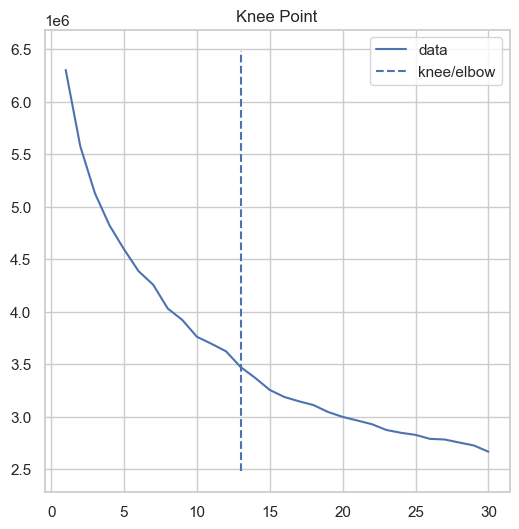

Número óptimo de clusters (codo): 13


In [29]:
# Determinar el rango de k (número de clusters)
k_range = range(1, n_components_95+1)
sse = []

# Calcular el SSE para cada número de clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca[:, :n_components_95])  # Usar los primeros componentes principales que explican el 95% de la varianza
    sse.append(kmeans.inertia_)  # Inertia es el SSE

# Usar kneed para encontrar el codo
kneedle = KneeLocator(k_range, sse, curve='convex', direction='decreasing')
kneedle.plot_knee()
plt.show()

# Imprimir el número de clusters en el codo
print(f'Número óptimo de clusters (codo): {kneedle.elbow}')

In [30]:
# Definir el rango de clusters a probar
range_n_clusters = list(range(2, 15))  
silhouette_scores = []

# Calcular el índice de Silhouette para cada número de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_processed)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_processed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Índice de Silhouette para Diferentes Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silhouette')
plt.xticks(range_n_clusters)
plt.grid()

# Usar kneed para encontrar el número óptimo de clusters
kneedle = KneeLocator(range_n_clusters, silhouette_scores, curve='convex', direction='increasing')
optimal_n_clusters = kneedle.elbow

# Marcar el número óptimo en el gráfico
plt.axvline(x=optimal_n_clusters, color='r', linestyle='--')
plt.annotate(f'Óptimo: {optimal_n_clusters}', xy=(optimal_n_clusters, silhouette_scores[optimal_n_clusters-2]), 
             xytext=(optimal_n_clusters + 1, silhouette_scores[optimal_n_clusters-2] - 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

print(f'Número óptimo de clusters (KneeLocator): {optimal_n_clusters}')